### Project 2
Refer to the project writeup [here](https://rutgers.box.com/s/yqrov1mwv5kbpk557nvc5uhjbj4mla6d)

In [3]:
from math import exp
import random

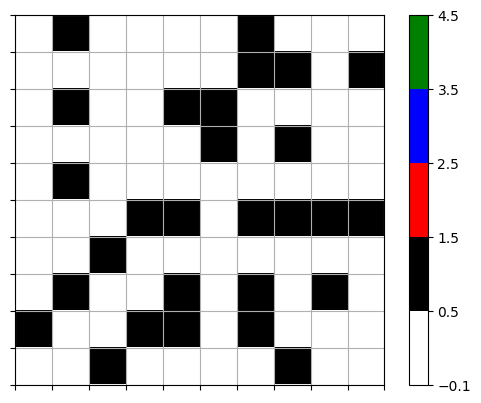

[(1, 4), (0, 3), (0, 5)]

In [4]:
from ship import ship
# Confirming our import works
space_ship = ship.CreateShip(10)
space_ship.OpenShip()
space_ship.ShowShip()
space_ship.getOpenNeighbors((0, 4))

In [5]:
# Now I want to work on bot 3
# Bot 3 and leak have random location on open cells
# If bot takes a "sense" action it has p = e^(-a(d-1)) of getting a beep, given leak is d steps away

# d(i, j) is shortest path to (i, j), all we need to do is SSSP with BFS
def SSSP(ship2: ship, src: tuple):
    dist = {cell :  [float('inf'), []] for cell in ship2.open}
    dist[src] = [0,[]]
    fringe = [src]
    while fringe:
        curr = fringe.pop(0)
        currDist = dist[curr][0]

        for neighbor in ship.getOpenNeighbors(ship2, curr):
            new_dist = 1 + currDist
            if new_dist < dist[neighbor][0]:
                dist[neighbor] = [new_dist, dist[curr][1]+[neighbor]]
                fringe.append(neighbor)
    return dist


# Initially all open cells should have the same probability of containing a leak
# What is P(leak is nearby | beep) = P(beep | leak)*P(leak) / P(beep)

def sense(botloc, leakloc, alpha, ship2): #Assuming botloc and leakloc are tuples (row, col)
    dist = SSSP(ship2, botloc)
    d = dist[leakloc][0]
    prob = exp(-alpha*(d-1))
    if random.random() < prob:
        return True, prob
    return False, prob

# To determine the next cell we visit:
# - Determine Max P(leak in cell x)
# Put all cells with this probability into a list
# Go to the closest one from this list

def updateProbs(currProbs, senseRes, ship, dist, alpha):
    newProbs = {}
    if senseRes:
        # Find P(beep)
        denom = sum(currProbs[k] * exp(-alpha*(dist[k][0]-1)) for k in ship.open)
    else:
        # Find P(!beep)
        denom = sum(currProbs[k] * (1 - exp(-alpha*(dist[k][0]-1))) for k in ship.open)
    for cell in ship.open:
        if senseRes:
            p_data_evidence = exp(-alpha * (dist[cell][0]-1))
        else:
            p_data_evidence = 1-exp(-alpha * (dist[cell][0]-1))
        # Essentially, if we get a beep: P(leak in cell)* P(beep at i | leak in cell)/ P(beep)
        new_prob = (currProbs[cell]*p_data_evidence)/denom 
        newProbs[cell] = new_prob
    return newProbs

# Assuming that we went to this cell and we did not find leak
def newCell(cell_loc, currProbs):
    prob_cell = currProbs[cell_loc]
    denom = 1 - prob_cell
    newProbs = {}
    for cell in currProbs.keys():
        newProbs[cell] = currProbs[cell]/denom
    newProbs[cell_loc] = 0
    return newProbs

# Find the cell with max probability, breaking ties by finding min distance
def nextCell(probabilities:dict , distances:dict):
    max_prob = max(probabilities.values())
    max_prob_keys = [key for key,value in probabilities.items() if value==max_prob]
    return min(max_prob_keys, key=lambda key: distances[key][0])

# If we move to a cell and dont detect leak, do we update all probs to be old prob/1 - prob of this cell
def Bot3(ship, alpha):
    opens = list(ship.open)
    while True:
        botloc, leakloc = random.sample(opens, 2)
        if botloc != leakloc: break
    print(f'bot started at: {botloc}, leak is at: {leakloc}')
    start_prob = 1/(len(opens)-1) #Probability leak is in any open cell is 1/# of possible cells
    probs = {cell: start_prob for cell in opens if cell != botloc}
    probs[botloc] = 0
    game_over,t, moves = False,0,[botloc]
    while not game_over:
        senseRes,_ = sense(botloc, leakloc, alpha, ship)
        t+=1 # Sense action takes one time step
        distances = SSSP(ship, botloc)
        probs = updateProbs(probs, senseRes, ship, distances,alpha)
        next_cell = nextCell(probs, distances)
        for loc in distances[next_cell][1]:
            moves.append(loc)
            if loc == leakloc:
                game_over = True
                return game_over, t, moves
            # Set the p(leak in this cell) = 0, and update other probs thru normalization. 
            # Note that this won't change cell with max prob b/c ratio of probabilities will remain the same
            probs = newCell(loc, probs)
            t+=1
        if set(moves)==ship.open: break # This means something went wrong and we fucked up
    return game_over, t, ['Bozo']
    


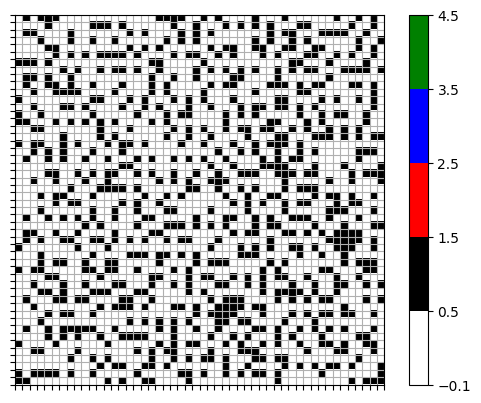

In [36]:
space_ship = ship.CreateShip(50)
space_ship.OpenShip()
space_ship.populateClosedCells()
space_ship.ShowShip()

In [38]:
Bot3(space_ship, 0.3)

bot started at: (8, 9), leak is at: (34, 38)


(True,
 4820,
 [(8, 9),
  (9, 9),
  (10, 9),
  (10, 10),
  (10, 11),
  (10, 12),
  (11, 12),
  (12, 12),
  (13, 12),
  (14, 12),
  (15, 12),
  (15, 13),
  (15, 14),
  (16, 14),
  (16, 15),
  (16, 16),
  (17, 16),
  (18, 16),
  (18, 17),
  (19, 17),
  (20, 17),
  (21, 17),
  (22, 17),
  (23, 17),
  (23, 18),
  (24, 18),
  (25, 18),
  (26, 18),
  (26, 19),
  (27, 19),
  (27, 20),
  (27, 21),
  (27, 22),
  (27, 23),
  (28, 23),
  (29, 23),
  (29, 24),
  (30, 24),
  (31, 24),
  (31, 25),
  (32, 25),
  (33, 25),
  (34, 25),
  (34, 26),
  (34, 27),
  (34, 28),
  (34, 29),
  (34, 30),
  (35, 30),
  (36, 30),
  (37, 30),
  (37, 31),
  (38, 31),
  (39, 31),
  (40, 31),
  (40, 32),
  (41, 32),
  (41, 33),
  (41, 34),
  (42, 34),
  (43, 34),
  (44, 34),
  (45, 34),
  (45, 35),
  (45, 36),
  (45, 37),
  (46, 37),
  (46, 38),
  (46, 39),
  (46, 40),
  (46, 41),
  (46, 42),
  (46, 43),
  (46, 44),
  (47, 44),
  (48, 44),
  (48, 45),
  (48, 46),
  (48, 47),
  (48, 48),
  (9, 9),
  (10, 9),
  (10, 10)

In [6]:
# Now let's start coding for Bot 7. Basically, we are going to have same algorithms and methods for updating probabilities
# but now the bot should keep going until it patches up 2 leaks

def Bot7(ship, alpha):
    opens = list(ship.open)
    # Now we initialize two random leak locations that are distinct
    while True:
        botloc, leak1loc, leak2loc = random.sample(opens, 3)
        if len(set([botloc, leak1loc, leak2loc])) == 3: break
    print(f'bot started at: {botloc}, leak 1 is at: {leak1loc}, leak 2 is at: {leak2loc}')
    start_prob = 2/(len(opens)-1)
    probs = {cell: start_prob for cell in opens if cell != botloc}
    probs[botloc] = 0
    leak1found, leak2found = False, False
    t, moves = 0, [botloc]
    while not leak1found or not leak2found:
        # We get sense results first based off the first leak, then once that's found based on the 2nd leak
        if not leak1found:
            senseRes, _ = sense(botloc, leak1loc, alpha, ship)
        elif not leak2found:
            senseRes, _ = sense(botloc, leak2loc, alpha, ship)
        t+=1
        distances = SSSP(ship, botloc)
        probs = updateProbs(probs, senseRes, ship, distances,alpha)
        next_cell = nextCell(probs, distances)
        for loc in distances[next_cell][1]:
            moves.append(loc)
            if loc == leak1loc:
                leak1found = True
            elif loc == leak2loc:
                leak2found = True
            if leak1found and leak2found:
                return True, t, moves
            # Set the p(leak in this cell) = 0, and update other probs thru normalization. 
            # Note that this won't change cell with max prob b/c ratio of probabilities will remain the same
            probs = newCell(loc, probs)
            t+=1
        if set(moves)==ship.open: break # This means something went wrong and we fucked up
    return False, t, ['Bozo']
        
        
    

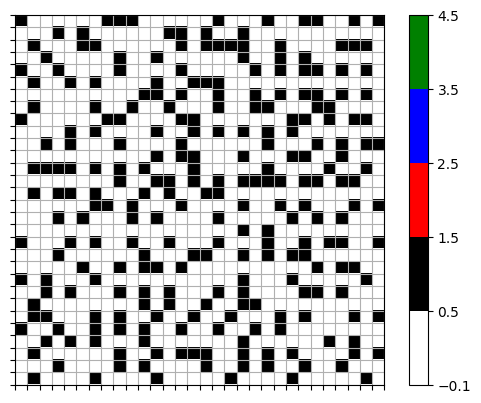

In [15]:
space_ship = ship.CreateShip(30)
space_ship.OpenShip()
space_ship.populateClosedCells()
space_ship.ShowShip()

In [19]:
Bot7(space_ship, 0.5)

bot started at: (25, 11), leak 1 is at: (3, 20), leak 2 is at: (7, 13)


(True,
 2147,
 [(25, 11),
  (25, 12),
  (24, 12),
  (24, 13),
  (23, 13),
  (22, 13),
  (21, 13),
  (21, 14),
  (20, 14),
  (20, 15),
  (20, 16),
  (19, 16),
  (19, 17),
  (18, 17),
  (17, 17),
  (16, 17),
  (15, 17),
  (14, 17),
  (13, 17),
  (12, 17),
  (11, 17),
  (10, 17),
  (9, 17),
  (8, 17),
  (7, 17),
  (6, 17),
  (5, 17),
  (5, 18),
  (5, 19),
  (5, 20),
  (4, 20),
  (3, 20),
  (2, 20),
  (1, 20),
  (1, 21),
  (1, 22),
  (1, 23),
  (1, 24),
  (1, 25),
  (1, 26),
  (1, 27),
  (1, 28),
  (1, 29),
  (25, 12),
  (24, 12),
  (24, 13),
  (23, 13),
  (22, 13),
  (21, 13),
  (21, 14),
  (20, 14),
  (20, 15),
  (20, 16),
  (19, 16),
  (19, 17),
  (18, 17),
  (17, 17),
  (16, 17),
  (15, 17),
  (14, 17),
  (13, 17),
  (12, 17),
  (11, 17),
  (10, 17),
  (9, 17),
  (8, 17),
  (7, 17),
  (6, 17),
  (5, 17),
  (5, 18),
  (5, 19),
  (5, 20),
  (4, 20),
  (3, 20),
  (2, 20),
  (1, 20),
  (1, 21),
  (1, 22),
  (1, 23),
  (1, 24),
  (1, 25),
  (1, 26),
  (1, 27),
  (1, 28),
  (0, 28),
  (25, 1